In [27]:
%pip install mne

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\LapTop\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
from sklearn.model_selection import train_test_split, GridSearchCV
from mne.time_frequency import tfr_morlet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

Extracting EDF parameters from C:\Users\LapTop\Downloads\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 681070  =      0.000 ...  2724.280 secs...
Shape of EEG data before dropping EOG channels: (25, 681071)


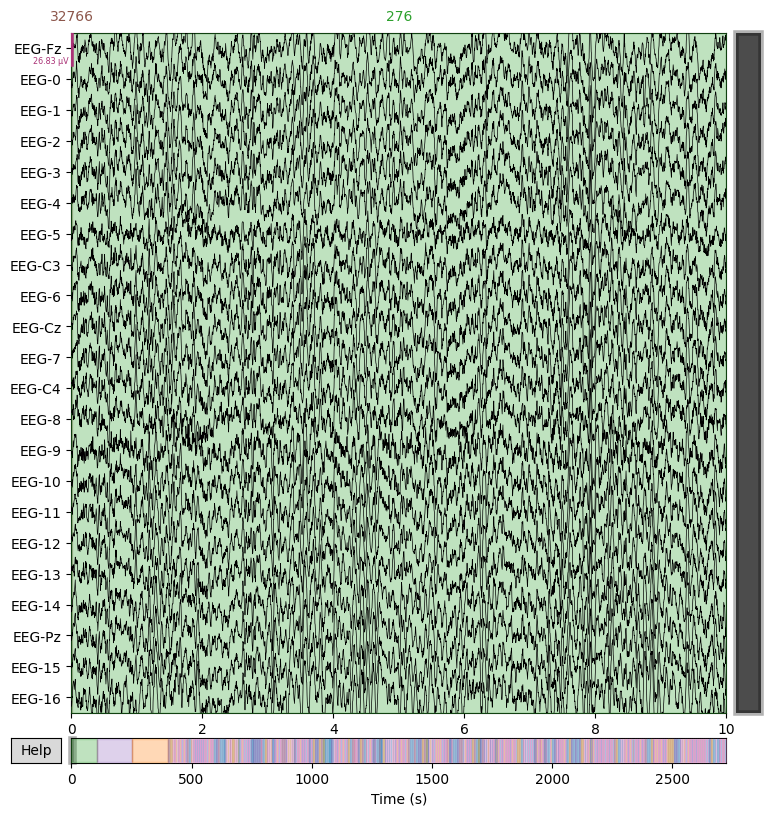

Shape of EEG data after dropping EOG channels: (22, 681071)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 237 samples (0.948 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


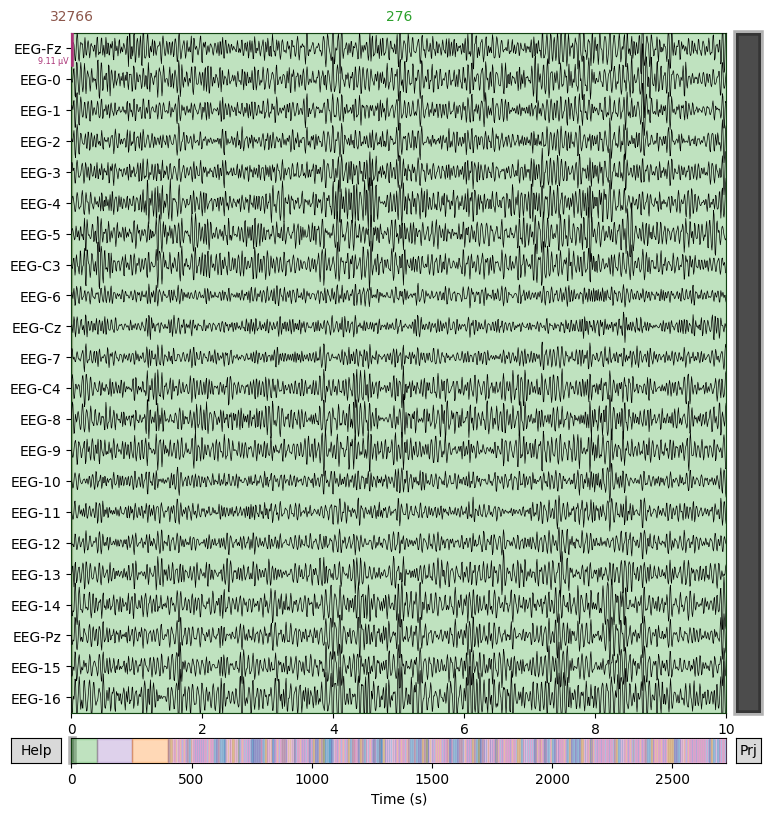

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 288 events and 176 original time points ...


C:\Users\LapTop\AppData\Local\Temp\ipykernel_15736\3086954044.py:32: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(fmin=0.5, fmax=50, tmin=0, tmax=None, proj=True, n_fft=2048, picks='eeg', show=True)
C:\Users\LapTop\AppData\Local\Temp\ipykernel_15736\3086954044.py:32: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0.5, fmax=50, tmin=0, tmax=None, proj=True, n_fft=2048, picks='eeg', show=True)
C:\Users\LapTop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped
Using data from preloaded Raw for 288 events and 176 original time points ...
Using data from preloaded Raw for 10 events and 176 original time points ...


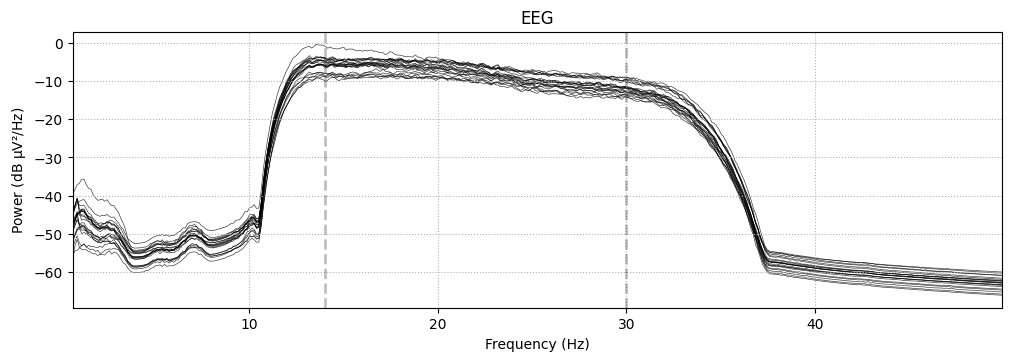

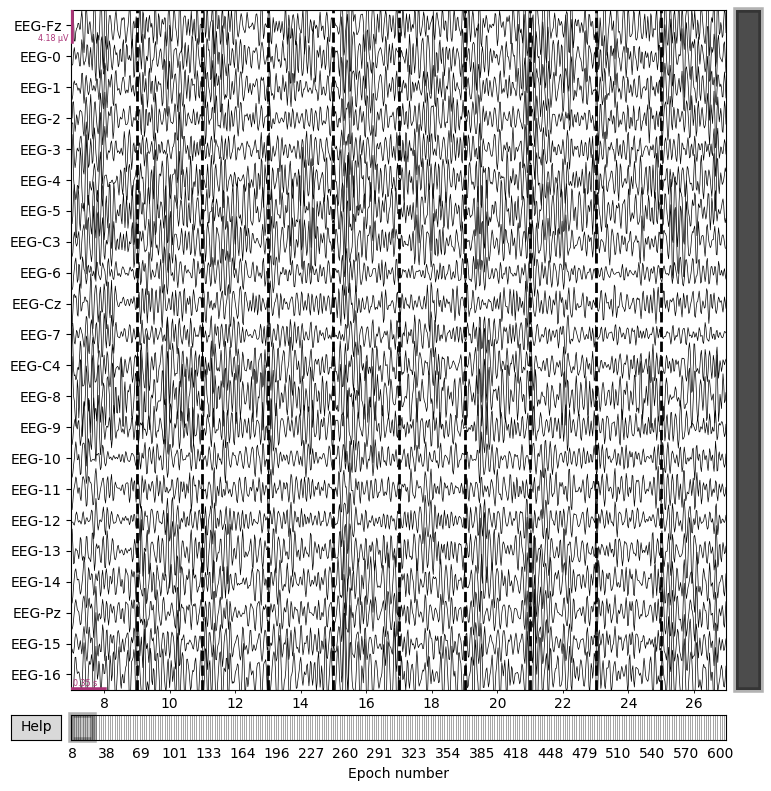

Using data from preloaded Raw for 288 events and 176 original time points ...
Shape of extracted features: (288, 22, 176)


In [29]:
import mne
import numpy as np

# Read the EEG data from the specified path using the GDF format
raw = mne.io.read_raw_gdf(r"C:\Users\LapTop\Downloads\A07T.gdf", preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])

print(f"Shape of EEG data before dropping EOG channels: {raw.get_data().shape}")

# Drop the EOG channels from the raw data
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
raw.plot(n_channels=22, scalings='auto', title='Raw EEG Data', show=True, block=True)
print(f"Shape of EEG data after dropping EOG channels: {raw.get_data().shape}")

raw.set_eeg_reference(ref_channels='average', projection=True)
# raw.filter(0.5, 4, fir_design='firwin')
# raw.filter(4, 8, fir_design='firwin')
# raw.filter(8, 13, fir_design='firwin')
raw.filter(14, 30, fir_design='firwin')
# raw.filter(30, 100, fir_design='firwin')
# raw.filter(0.5, 30, fir_design='firwin')

# raw.set_eeg_reference(ref_channels='average', projection=True)

raw.notch_filter(50)

raw.plot(n_channels=22, scalings='auto', title='Raw EEG Data', show=True, block=True)



# Plot Power Spectral Density (PSD)
raw.plot_psd(fmin=0.5, fmax=50, tmin=0, tmax=None, proj=True, n_fft=2048, picks='eeg', show=True)

# Extract events from annotations in the raw data
events = mne.events_from_annotations(raw)

# Create epochs based on the extracted events and specified event IDs
epochs = mne.Epochs(raw, events[0], event_id=[7, 8, 9, 10], on_missing='warn')

# Plot epochs
epochs.plot(n_epochs=10, n_channels=22, scalings='auto', title='Epochs', show=True, block=True)

# Extract labels from the epochs events
labels = epochs.events[:, -1]

# Extract EEG features (data) from the epochs
features = epochs.get_data()

features_normalized = (features - np.min(features)) / (np.max(features) - np.min(features))

# Print the shape of the extracted features
print("Shape of extracted features:", features_normalized.shape)

In [30]:
#Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

In [31]:
# for i in range (X_train.shape[0]):
#   # print(X_train[i].shape)
#   df = pd.DataFrame(X_train[i])
#   df.to_csv(f'C:/Users/LapTop/Downloads/test/{i}_{y_train[i]}.csv', index=False)

In [32]:
# #make a directory

# import os
# os.mkdir('test')

In [33]:
# import os
# import pandas as pd

# # Create the directory if it doesn't exist
# directory = 'C:/Users/LapTop/Downloads/test'
# if not os.path.exists(directory):
#     os.mkdir(directory)

# # Loop through X_train and save each entry as a CSV
# for i in range(X_train.shape[0]):
#     df = pd.DataFrame(X_train[i])
#     df.to_csv(f'{directory}/{i}_{y_train[i]}.csv', index=False)

In [34]:
# import os

# # Create the directory if it doesn't exist
# directory = 'C:/Users/LapTop/Downloads/test'
# if not os.path.exists(directory):
#     os.mkdir(directory)

# # Save features and labels
# np.save(os.path.join(directory, 'X_train.npy'), X_train)
# np.save(os.path.join(directory, 'X_test.npy'), X_test)
# np.save(os.path.join(directory, 'y_train.npy'), y_train)
# np.save(os.path.join(directory, 'y_test.npy'), y_test)


In [35]:
# import os
# import zipfile
# from IPython.display import FileLink


In [36]:
# from IPython.display import FileLink

# def zip_directory(directory_path, zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, dirs, files in os.walk(directory_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 zipf.write(file_path, os.path.relpath(file_path, directory_path))
# zip_file_path = 'data.zip'
# zip_directory('data', zip_file_path)

# # Step 4: Create a download link
# FileLink(zip_file_path)


In [37]:
# ica = mne.preprocessing.ICA(n_components=15, max_iter='auto', random_state=0, method='infomax')
# ica.fit(epochs.copy())

In [38]:
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_val = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

In [39]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_test.shape)

X_train:  (230, 22, 176)
X_val:    (58, 22, 176)
y_train:  (230,)
y_val:    (58,)


In [40]:
# Extract features using CSP and SelectKBest
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_val_csp = csp.transform(X_val)

Computing rank from data with rank=None


    Using tolerance 2.4 (2.2e-16 eps * 22 dim * 4.9e+14  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.


In [41]:
# SVM classifier with hyperparameter tuning
pipeline = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.1, 1, 10], 'svc__gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_csp, y_train)
best_params = grid_search.best_params_

In [42]:
# Train classifier with best parameters
classifier = SVC(C=best_params['svc__C'], gamma=best_params['svc__gamma'])
classifier.fit(X_train_csp, y_train)

# Evaluate classifier
y_pred = classifier.predict(X_val_csp)
# Evaluate SVM model
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy of SVM model: {:.2f}".format(accuracy_svm))
print("Classification Report for SVM model:")
print(classification_report(y_test, y_pred))

Accuracy of SVM model: 0.31
Classification Report for SVM model:
              precision    recall  f1-score   support

           7       0.50      0.29      0.37        17
           8       0.22      0.13      0.17        15
           9       0.18      0.40      0.25        10
          10       0.41      0.44      0.42        16

    accuracy                           0.31        58
   macro avg       0.33      0.32      0.30        58
weighted avg       0.35      0.31      0.31        58



In [43]:
# Initialize and train the SVM model with Linear kernel
svm_model = SVC(kernel='linear', C=best_params['svc__C'], gamma=best_params['svc__gamma'])
svm_model.fit(X_train_csp, y_train)

# Predict labels for test set
y_pred_svm = svm_model.predict(X_val_csp)

# Calculate accuracy and print classification report for SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model: {:.2f}".format(accuracy_svm))
print("Classification Report for SVM model:")
print(classification_report(y_test, y_pred_svm))


Accuracy of SVM model: 0.36
Classification Report for SVM model:
              precision    recall  f1-score   support

           7       0.40      0.35      0.38        17
           8       0.36      0.27      0.31        15
           9       0.21      0.40      0.28        10
          10       0.54      0.44      0.48        16

    accuracy                           0.36        58
   macro avg       0.38      0.36      0.36        58
weighted avg       0.40      0.36      0.37        58



In [44]:
# Initialize and train the SVM model with rbf Kernel
svm_model = SVC(kernel='rbf', C=100) #c was = 2 and accurcy = 45
svm_model.fit(X_train_csp, y_train)

# Predict labels for test set
y_pred_svm = svm_model.predict(X_val_csp)

# Calculate accuracy and print classification report for SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model: {:.2f}".format(accuracy_svm))
print("Classification Report for SVM model:")
print(classification_report(y_test, y_pred_svm))


Accuracy of SVM model: 0.52
Classification Report for SVM model:
              precision    recall  f1-score   support

           7       0.60      0.71      0.65        17
           8       0.38      0.33      0.36        15
           9       0.36      0.40      0.38        10
          10       0.64      0.56      0.60        16

    accuracy                           0.52        58
   macro avg       0.50      0.50      0.50        58
weighted avg       0.52      0.52      0.51        58



In [45]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6 , random_state=42)
rf_model.fit(X_train_csp, y_train)

# Predict labels for test set using Random Forest
y_pred_rf = rf_model.predict(X_val_csp)

# Calculate accuracy and print classification report for Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest model: {:.2f}".format(accuracy_rf))
print("Classification Report for Random Forest model:")
print(classification_report(y_test, y_pred_rf))

Accuracy of Random Forest model: 0.50
Classification Report for Random Forest model:
              precision    recall  f1-score   support

           7       0.53      0.53      0.53        17
           8       0.47      0.47      0.47        15
           9       0.27      0.30      0.29        10
          10       0.67      0.62      0.65        16

    accuracy                           0.50        58
   macro avg       0.48      0.48      0.48        58
weighted avg       0.51      0.50      0.50        58



In [46]:
from sklearn.linear_model import LogisticRegression
Logistic_Regression = LogisticRegression(C=4)
Logistic_Regression.fit(X_train_csp, y_train)
# Predict labels for test set
y_pred_svm = Logistic_Regression.predict(X_val_csp)

# Calculate accuracy and print classification report for SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of LogisticRegression model: {:.2f}".format(accuracy_svm))
print("Classification Report for LogisticRegression model:")
print(classification_report(y_test, y_pred_svm))


Accuracy of LogisticRegression model: 0.36
Classification Report for LogisticRegression model:
              precision    recall  f1-score   support

           7       0.47      0.47      0.47        17
           8       0.36      0.27      0.31        15
           9       0.12      0.20      0.15        10
          10       0.50      0.44      0.47        16

    accuracy                           0.36        58
   macro avg       0.36      0.34      0.35        58
weighted avg       0.39      0.36      0.37        58



In [47]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\LapTop\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [48]:
from xgboost import XGBClassifier
model = XGBClassifier(gamma = 0.001 , n_estimators=150)
model.fit(X_train_csp, y_train-7)
y_pred_svm = model.predict(X_val_csp)

# Calculate accuracy and print classification report for SVM model
accuracy_svm = accuracy_score(y_test-7, y_pred_svm)
print("Accuracy of xgboost model: {:.2f}".format(accuracy_svm))
print("Classification Report for xgboost model:")
print(classification_report(y_test-7, y_pred_svm))

Accuracy of xgboost model: 0.52
Classification Report for xgboost model:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.47      0.47      0.47        15
           2       0.42      0.50      0.45        10
           3       0.56      0.56      0.56        16

    accuracy                           0.52        58
   macro avg       0.51      0.51      0.51        58
weighted avg       0.52      0.52      0.52        58



In [49]:
import joblib

# Save the trained SVM model
joblib.dump(classifier, 'svm_model.pkl')
# Save the trained XGBoost model
joblib.dump(model, 'xgboost_model.pkl')
# Save the CSP model
joblib.dump(csp, 'csp.pkl')

['csp.pkl']

In [50]:
%pip install tk

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\LapTop\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [51]:
# UI Code For xgboost Model
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import joblib
import os
import pandas as pd

# Load the saved models
xgboost_model = joblib.load('xgboost_model.pkl')
csp = joblib.load('csp.pkl')

# Define the class to action mapping
class_to_action_mapping = {
    0: ('Tongue', 'Eat'),
    1: ('Left Hand', 'Drink Water'),
    2: ('Right Hand', 'Go to Bathroom'),
    3: ('Feet', 'Sleep')
}

# Function to classify an action using preprocessed data
def classify_action(file_path):
    # Load the selected file
    eeg_data = pd.read_csv(file_path).values
    eeg_data = eeg_data.reshape(1, eeg_data.shape[0], eeg_data.shape[1])
    
    # Extract features using CSP (no need to normalize again if already normalized)
    features_csp = csp.transform(eeg_data)
    
    # Predict using the trained XGBoost model
    action_class = xgboost_model.predict(features_csp)[0]
    
    # Map the predicted class to a class name and action
    class_name, action = class_to_action_mapping.get(action_class, ('Unknown', 'Unknown'))
    
    # Show the class name and predicted action in the UI
    messagebox.showinfo("Predicted Action", f"{class_name} ==> The system predicts you want to: {action}")

# Function to open a file dialog and get the selected file path
def browse_file():
    file_path = filedialog.askopenfilename(initialdir='C:/Users/LapTop/Downloads/test', title="Select EEG Data File", filetypes=(("CSV files", "*.csv"),))
    if file_path:
        classify_action(file_path)

# Create the main Tkinter window
root = tk.Tk()
root.title("Motor Imagery BCI Interface")

# Create a label
label = tk.Label(root, text="Choose an action to perform based on your motor imagery:")
label.pack(pady=10)

# Create a button to browse for a file
browse_button = tk.Button(root, text="Browse File", command=browse_file)
browse_button.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()


In [52]:
# UI Code For SVM Model
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import joblib
import os
import pandas as pd

# Load the saved models
svm_model = joblib.load('svm_model.pkl')
csp = joblib.load('csp.pkl')

# Define the class to action mapping
class_to_action_mapping = {
    7: ('Tongue', 'Eat'),
    8: ('Left Hand', 'Drink Water'),
    9: ('Right Hand', 'Go to Bathroom'),
    10: ('Feet', 'Sleep')
}

# Function to classify an action using preprocessed data
def classify_action(file_path):
    # Load the selected file
    eeg_data = pd.read_csv(file_path).values
    eeg_data = eeg_data.reshape(1, eeg_data.shape[0], eeg_data.shape[1])
    
    # Extract features using CSP (no need to normalize again if already normalized)
    features_csp = csp.transform(eeg_data)
    
    # Predict using the trained model
    action_class = svm_model.predict(features_csp)[0]
    
    # Map the predicted class to a class name and action
    class_name, action = class_to_action_mapping.get(action_class, ('Unknown', 'Unknown'))
    
    # Show the class name and predicted action in the UI
    messagebox.showinfo("Predicted Action", f"{class_name} ==> The system predicts you want to: {action}")

# Function to open a file dialog and get the selected file path
def browse_file():
    file_path = filedialog.askopenfilename(initialdir='C:/Users/LapTop/Downloads/test', title="Select EEG Data File", filetypes=(("CSV files", "*.csv"),))
    if file_path:
        classify_action(file_path)

# Create the main Tkinter window
root = tk.Tk()
root.title("Motor Imagery BCI Interface")

# Create a label
label = tk.Label(root, text="Choose an action to perform based on your motor imagery:")
label.pack(pady=10)

# Create a button to browse for a file
browse_button = tk.Button(root, text="Browse File", command=browse_file)
browse_button.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()
